In [56]:
! pip install catboost --quiet

In [57]:
!pip install ydata_profiling --quiet

In [58]:
!pip install pysrt --quiet

In [59]:
!pip install -U spacy --quiet

In [60]:
!pip install PyMuPDF --quiet

In [61]:
!python -m spacy download en_core_web_sm --quiet

2023-10-27 05:30:33.029020: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 05:30:33.029082: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 05:30:33.029123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 05:30:34.593847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [62]:
!pip install optuna

# Определение уровня сложности английского языка в фильмах

**Описание:** Просмотр фильмов на оригинальном языке - популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, т.ч. студент понимал 50 - 70 % диалогов.

**Цель проекта:** в течение 2х недель разработать ML решение для автоматического определения уровня сложности англоязычных фильмов. Метрика модели - accuracy.

**Описание данных:**

**1. Таблица в формате .xlsx** с разметкой фильмов с указанием id, наименования фильма и уровня сложности иностранного языка в нем согласно шкале CEFR (Common European Framework of Reference, CEFR) — системе уровней владения иностранным языком, используемая в Европейском союзе:
- A — Базовое знание (Basic User)

    - A1. Уровень Beginner (Начальный)
    - A2. Уровень Elementary (Базовый)
- B — Самоcтоятельное владение (Independent User)
    - B1. Уровень Intermediate (Средний)
    - B2. Уровень Upper-Intermediate (Выше среднего)
- C — Свободное владение (Proficient User)
    - C1. Уровень Advanced (Продвинутый)
    - C2. Уровень Proficiency (Владение в совершенстве)
    


**2. Файлы с субтитрами к фильмам в формате .srt,** разложенные по папкам.

**3. Списки словарного запаса Oxford по шкале CEFR в двух pdf-файлах.**

## Подготовка данных.

### Ознакомление с данными.

#### Импортируем необходимые для работы библиотеки.

In [63]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [64]:
import pandas as pd

import re
import pysrt
import difflib
from pathlib import Path

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer

import spacy

import fitz

import optuna

import string

import chardet

import matplotlib.pyplot as plt

import seaborn as sns

from ydata_profiling import ProfileReport

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix

#### Ознакамливаемся с файлом с разметками фильмов.

In [65]:
# Подключаем Google Drive к Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
folder_path = "/content/drive/My Drive/English level in movies/"

##### Открываем файл с разметкой фильмов и сохраняем в переменной.

In [67]:
df = pd.read_excel(folder_path + "movies_labels.xlsx")

##### Выводим первые 5 строк файла.

In [68]:
display(df.head(5))

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


#####  Выводим основную информацию датасета с разметкой фильмов методом info().

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      241 non-null    int64 
 1   Movie   241 non-null    object
 2   Level   241 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.8+ KB


### Предобработка данных.

#### В целях облегчения процесса поиска и обучения необходимой модели исключаем из датасета данные, не относящиеся к признакам.

In [70]:
df = df.drop(['id'], axis=1)
display(df.head(5))

,Movie,Level
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+


#### Удаляем из датасета полные дубликаты.

In [71]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   239 non-null    object
 1   Level   239 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


#### Дополняем датасет данными субтитров.

##### Добавляем столбец path и вносим в него информацию о пути к файлу с субтитрами для каждого фильма.

In [72]:
%%time

# Указываем начальный путь к папке Subtitles_all, которая находится в folder_path
base_path = Path(folder_path + 'Subtitles_all')

# Папки с субтитрами
folders = ['A2', 'B1', 'B2', 'C1', 'Subtitles']

# Добавляем новый столбец в датафрейм
df['path'] = None

def find_sub_path(base_path, folders, movie):
    for folder in folders:
        # Получение списка всех файлов .srt в каждой папке
        subs = list((base_path / folder).glob('*.srt'))
        # Получение списка имен файлов .srt вместе с расширением
        sub_names = [sub.name for sub in subs]

        # Проверка на наличие точного совпадения
        if f"{movie}.srt" in sub_names:
            return str((base_path / folder / f"{movie}.srt"))  # точное совпадение, возвращаем путь
    return None  # если точного совпадения не нашлось

# Перебор по фильмам в датафрейме
for idx, row in df.iterrows():
    movie = row['Movie']
    # Поиск пути к субтитрам
    sub_path = find_sub_path(base_path, folders, movie)
    # Если путь найден - записываем его
    if sub_path:
        df.loc[idx, 'path'] = sub_path
    else:  # Если точного совпадения нет, пробуем найти ближайшее
        for folder in folders:
            subs = list((base_path / folder).glob('*.srt'))
            sub_names = [sub.name for sub in subs]

            # Использование difflib для получения наиболее похожего имени файла на имя фильма
            match = difflib.get_close_matches(movie, sub_names, n=1)

            # Если есть совпадение, записываем в датафрейм полный путь к файлу и выходим из цикла
            if match:
                df.loc[idx, 'path'] = str(
                    (base_path / folder / match[0]))
                break

CPU times: user 280 ms, sys: 104 ms, total: 384 ms
Wall time: 1.39 s


##### Добавляем столбец text и вносим в него субтитры для каждого фильма.

In [73]:
# определяем кодировку каждого файла с субтитрами для последующей работы с ними
def detect_encoding(file_path):
    rawdata = open(file_path, 'rb').read()
    result = chardet.detect(rawdata)
    return result['encoding']

In [74]:
%%time

def get_subs_text(path):
    encoding = detect_encoding(path)
    subs = pysrt.open(str(path), encoding=encoding)
    return ' '.join([sub.text for sub in subs])


df['text'] = df['path'].apply(get_subs_text)

CPU times: user 1min 22s, sys: 323 ms, total: 1min 22s
Wall time: 1min 38s


#### Выявляем и устраняем дубликаты по столбцу Movie.

In [75]:
display(df[df.duplicated('Movie', keep=False)].sort_values('Movie'))

,Movie,Level,path,text
75,The_blind_side(2009),B2,/content/drive/My Drive/English level in movie...,[CROWD CHEERING IN DISTANCE] LElGH ANNE: There...
84,The_blind_side(2009),B1,/content/drive/My Drive/English level in movie...,[CROWD CHEERING IN DISTANCE] LElGH ANNE: There...
83,The_terminal(2004),B1,/content/drive/My Drive/English level in movie...,"<font color=""#D900D9"">(AIRPLANE APPROACHES)</f..."
99,The_terminal(2004),"A2/A2+, B1",/content/drive/My Drive/English level in movie...,"<font color=""#D900D9"">(AIRPLANE APPROACHES)</f..."


Устраняем выявленные дубликаты.

In [76]:
# Указываем смежные рейтинги для фильмов
df.loc[83, 'Level'] = "A2, B1"
df.loc[75, 'Level'] = "B1, B2"
# После чего удаляем дубликаты
df = df.drop_duplicates(subset='Movie', keep='first')

#### Выводим строки с фильмами, для которых не были найдены субтитры.

In [77]:
df[df['path'].isnull()]

,Movie,Level,path,text


После выявления таких фильмов субтитры к ним были скачаны с ресурса https://subscene.com/subtitles/ и добавлены в папку с субтитрами.

#### Осуществляем первичную очистку субтитров от лишней информации.

In [78]:
%%time

HTML = r'<.*?>'
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Z ]+[\)\]]'
LETTERS = r'[^a-zA-Z\'.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'

def clean_subs(subs):
    txt = re.sub(HTML, ' ', subs) #html тэги меняем на пробел
    txt = re.sub(TAG, ' ', txt) #тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) #комменты меняем на пробел
    txt = re.sub(LETTERS, ' ', txt) #все что не буквы меняем на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    txt = re.sub(DOTS, r'.', txt)
    txt = txt.encode('ascii', 'ignore').decode() #удаляем все что не ascii символы
    txt = ".".join(txt.lower().split('.')[1:-1]) #удаляем первый и последний субтитр (обычно это реклама)
    return txt

df['text'] = df['text'].apply(clean_subs)

CPU times: user 1.17 s, sys: 1.93 ms, total: 1.18 s
Wall time: 1.22 s


Ознакамливаемся с результатом очистки.

In [79]:
print(df['text'][0])

 enjoy the flick ben on phone michelle, please don't hang up. just talk to me, okay? i can't believe you just left. michelle. come back. please say something. michelle, talk to me. look, we had an argument. couples fight. that is no reason to just leave everything behind. running away isn't gonna help it any. michelle, please. newscaster more details on that. elsewhere today, power has still not been restored to many cities on the southern seaboard in the wake of this afternoon's widespread blackout. while there had been some inclement weather in the region, the problem seems linked to what authorities are calling a catastrophic power surge that has crippled traffic in the area. no. no! damn. okay. okay, please. please. please don't hurt me. please. just let me go, okay? i won't tell anybody. i promise, okay? please just let me go. please. man you need fluids. you were in shock. what are you going to do to me? i'm going to keep you alive. work on getting handy with these. my boyfriend 

#### Осуществляем лемматизацию и дальнейшую очистку текста от стоп-слов, имён и знаков пунктуации. Готовим текст к векторизации.

In [80]:
%%time

# Загрузка стоп-слов и списка имен
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('names', quiet=True)

CPU times: user 28.1 ms, sys: 2.99 ms, total: 31.1 ms
Wall time: 32.5 ms


True

In [81]:
from nltk.corpus import names

In [82]:
# Загрузка модели языка для SpaCy (например, "en_core_web_sm")
spacy_model = "en_core_web_sm"
nlp = spacy.load(spacy_model)

In [83]:
%%time

LETTERS = r'[^a-zA-Z\' ]'
interjections = r'\b(oh|uh|um|mmm|hmm|ahaa|aaaaah|aaaagggghhhhh|aaah|aah|hey)\b'

# Объединяем список имен мужчин и женщин и приводим их к нижнему регистру
name_list = [name.lower() for name in names.words('male.txt') + names.words('female.txt')]

nlp = spacy.load('en_core_web_sm')

def clean_subs_again(txt):
    txt = re.sub(interjections, ' ', txt)
    txt = re.sub(LETTERS, ' ', txt)

    doc = nlp(txt)

    # Теперь также проверяем, есть ли лемматизированное слово в списке имен
    txt = [token.lemma_ for token in doc if not token.is_stop and token.lemma_ not in name_list]

    txt = ' '.join(txt)

    # Удаление пробелов в начале строки
    txt = txt.lstrip()

    # Замена "'' и отдельно стоящих 't' и 'r' на пробелы
    txt = re.sub(r"'", ' ', txt)
    txt = re.sub(r'\b(t|r)\b', ' ', txt)

    txt = re.sub(SPACES, r'\1', txt)

    return txt

df['clean_text'] = df['text'].apply(clean_subs_again)

CPU times: user 7min 41s, sys: 14.8 s, total: 7min 55s
Wall time: 8min 7s


Ознакамливаемся с результатом очистки.

In [84]:
print(df['clean_text'][0])

enjoy flick phone hang talk okay believe leave come talk look argument couple fight reason leave run away gon na help newscaster detail today power restore city southern seaboard afternoon widespread blackout inclement weather region problem link authority call catastrophic power surge cripple traffic area damn okay okay hurt let okay wo tell anybody promise okay let man need fluid shock go go alive work get handy boyfriend expect send cop look sorry look get fight respect think try generosity extend far egg toradol help pain let look wallet give save life think acceptable mean find save life bring understand attack attack big sure chemical nuclear safe exactly underneath farmhouse mile outside lake drive north accident turn road drive save life leave okay thank save life guess hospital leave attack mean fallout contaminate air ground work long safe depend proximity close blast year maybe talk weapon know russians develop nasty stuff martian finally figure weapon russkie look like stic

#### Переименовываем столбцы в соответствии с PEP8.

In [85]:
df.columns = ['movie', 'level', 'path', 'text', 'clean_text']
display(df.head(5))

,movie,level,path,text,clean_text
0,10_Cloverfield_lane(2016),B1,/content/drive/My Drive/English level in movie...,"enjoy the flick ben on phone michelle, please...",enjoy flick phone hang talk okay believe leave...
1,10_things_I_hate_about_you(1999),B1,/content/drive/My Drive/English level in movie...,"so, cameron. here you go. nine schools in yea...",school year army brat yeah dad sure wo find pa...
2,A_knights_tale(2001),B2,/content/drive/My Drive/English level in movie...,two minutes or forfeit. lend us those. right....,minute forfeit lend right leave dead eh score ...
3,A_star_is_born(2018),B2,/content/drive/My Drive/English level in movie...,black eyes open wide it's time to testify the...,black eye open wide time testify room lie gone...
4,Aladdin(1992),A2/A2+,/content/drive/My Drive/English level in movie...,"please, please, come closer. too close. a lit...",come close close little close welcome agrabah ...


#### Создаем списки слов по уровням CEFR основе файлов с такими списками от Oxford в формате pdf.

In [86]:
%%time

# создаем функцию для создания списка слов из первого pdf-файла
def get_words_by_level(pdf_path):
    # Открываем документ
    doc = fitz.open(pdf_path)

    words_by_level = {"A1": [], "A2": [], "B1": [], "B2": []}
    current_level = None

    for page in doc:
        # Получаем данные о блоках текста на странице в виде JSON
        blocks = page.get_text("dict")["blocks"]

        for block in blocks:
            if "lines" in block:
                for line in block["lines"]:
                    for span in line["spans"]:
                        text = span["text"]
                        # Проверяем, является ли текущий блок подзаголовком уровня
                        if text in ["A1", "A2", "B1", "B2"]:
                            current_level = text
                        # Если это не подзаголовок, и у нас уже есть текущий уровень, добавляем слово
                        elif current_level and span['size'] == 9 and span['font'] == 'MyriadPro-Regular':
                            # Добавляем только первое слово в строке (игнорируем определения и примеры использования)
                            word = text.split()[0]
                            word = word.strip(' ,\'"')  # Удаляем пробелы, запятые и кавычки с концов слова
                            # Удаляем цифры в конце слов
                            word = re.sub(r'\d+$', '', word)
                            # Игнорируем пустые строки и слова, начинающиеся с '('
                            if word and not word.startswith('('):
                                words_by_level[current_level].append(word)

    return words_by_level

words_by_level_1 = get_words_by_level(folder_path + "The_Oxford_3000_by_CEFR_level.pdf")

# Для просмотра результатов выведите первые 10 слов каждого уровня
for level, words in words_by_level_1.items():
    print(f"{level}: {words[:10]}")


A1: ['a', 'about', 'above', 'across', 'action', 'activity', 'actor', 'actress', 'add', 'address']
A2: ['ability', 'able', 'abroad', 'accept', 'accident', 'according', 'achieve', 'act', 'active', 'actually']
B1: ['absolutely', 'academic', 'access', 'accommodation', 'account', 'achievement', 'act', 'ad', 'addition', 'admire']
B2: ['abandon', 'absolute', 'academic', 'acceptable', 'accompany', 'account', 'accurate', 'accuse', 'acknowledge', 'acquire']
CPU times: user 67.8 ms, sys: 3.95 ms, total: 71.7 ms
Wall time: 84.4 ms


In [87]:
%%time

# создаем функцию для создания списка слов из второго pdf-файла
def get_words_by_level(pdf_path):
    # Открываем документ
    doc = fitz.open(pdf_path)

    words_by_level = {"B2": [], "C1": []}
    current_level = None

    for page in doc:
        # Получаем данные о блоках текста на странице в виде JSON
        blocks = page.get_text("dict")["blocks"]

        for block in blocks:
            if "lines" in block:
                for line in block["lines"]:
                    for span in line["spans"]:
                        text = span["text"]
                        # Проверяем, является ли текущий блок подзаголовком уровня
                        if text in ["B2", "C1"]:
                            current_level = text
                            # Если мы обрабатываем второй файл, переименовываем уровень B2
                            if pdf_path == folder_path + "The_Oxford_5000_by_CEFR_level.pdf" and text == "B2":
                                current_level = "B2_plus"
                        # Если это не подзаголовок, и у нас уже есть текущий уровень, добавляем слово
                        elif current_level:
                            if text.strip():  # Проверяем, что строка не пустая
                                if span['size'] == 9 and span['font'] == 'MyriadPro-Regular':
                                    # Добавляем только первое слово в строке
                                    word = text.split()[0]
                                    word = word.strip(' ,\'"')  # Удаляем пробелы, запятые и кавычки с концов слова
                                    # Удаляем цифры в конце слов
                                    word = re.sub(r'\d+$', '', word)
                                    if word and not word.startswith('('):
                                        # Если текущего уровня нет в словаре, добавляем его
                                        if current_level not in words_by_level:
                                            words_by_level[current_level] = []
                                        words_by_level[current_level].append(word)

    # Если в списке B2 нет слов, удаляем его
    if "B2" in words_by_level and not words_by_level["B2"]:
        del words_by_level["B2"]

    return words_by_level

words_by_level_2 = get_words_by_level(folder_path + "The_Oxford_5000_by_CEFR_level.pdf")

# Для просмотра результатов выведите первые 10 слов каждого уровня
for level, words in words_by_level_2.items():
    print(f"{level}: {words[:10]}")

C1: ['abolish', 'abortion', 'absence', 'absent', 'absurd', 'abundance', 'abuse', 'academy', 'accelerate', 'acceptance']
B2_plus: ['absorb', 'abstract', 'accent', 'accidentally', 'accommodate', 'accomplish', 'accountant', 'accuracy', 'accurately', 'acid']
CPU times: user 47.9 ms, sys: 1e+03 ns, total: 47.9 ms
Wall time: 53.2 ms


### Создаем новые признаки на основе субтитров.

#### Рассчитываем количество уникальных слов в субтитрах к каждому фильму.

In [88]:
%%time

def count_unique_words(text):

    # Токенизация текста
    word_tokens = word_tokenize(text)

    # Возврат количества уникальных слов
    return len(set(word_tokens))

# добавляем полученную информацию в новый столбцец words
df['words'] = df['text'].apply(count_unique_words)

CPU times: user 28 s, sys: 44.3 ms, total: 28.1 s
Wall time: 28.2 s


#### Рассчитываем длительность субтитров в каждом фильме.

In [89]:
%%time

def calculate_subs_duration(subs_path):
    encoding = detect_encoding(subs_path)
    subs = pysrt.open(subs_path, encoding=encoding)
    total_duration = 0
    for sub in subs:
        total_duration += (sub.end - sub.start).seconds
    return total_duration

# добавляем полученную информацию в новый столбцец s_duration в минутах
df['s_duration'] = (df['path'].apply(calculate_subs_duration)/60).round(1)

CPU times: user 1min 16s, sys: 201 ms, total: 1min 17s
Wall time: 1min 18s


#### Рассчитываем длительность каждого фильма.

In [90]:
%%time

def calculate_movie_duration(subs_path):
    encoding = detect_encoding(subs_path)
    subs = pysrt.open(subs_path, encoding=encoding)
    start_time = subs[0].start.ordinal  # Время начала первой реплики
    end_time = subs[-1].end.ordinal  # Время окончания последней реплики
    duration = end_time - start_time
    return duration / 1000.0  # Конвертируем из миллисекунд в секунды

# добавляем полученную информацию в новый столбец m_duration в минутах
df['m_duration'] = (df['path'].apply(calculate_movie_duration)/60).round(1)

CPU times: user 1min 15s, sys: 217 ms, total: 1min 15s
Wall time: 1min 16s


#### Рассчитываем долю диалогов в каждом фильме.

In [91]:
df['s_ratio'] = (df['s_duration']/df['m_duration']).round(2)

#### Рассчитываем количество уникальных слов в минуту субтитров.

In [92]:
df['words_per_smin'] = (df['words']/df['s_duration']).round(1)

#### Рассчитываем количество уникальных слов в минуту фильма.

In [93]:
df['words_per_mmin'] = (df['words']/df['m_duration']).round(1)

#### Рассчитываем среднюю длину слов в каждом фильме.

In [94]:
%%time

def calculate_avg_word_size(subs_text):
    words = nltk.word_tokenize(subs_text)
    unique_words = set(words)  # Убираем дубликаты слов
    total_length = sum(len(word) for word in unique_words)
    return total_length / len(unique_words)

# добавляем полученную информацию в новый столбец avg_w_size в буквах
df['avg_w_size'] = (df['text'].apply(calculate_avg_word_size)).round(1)

CPU times: user 26.9 s, sys: 55.1 ms, total: 26.9 s
Wall time: 27 s


#### Рассчитываем среднюю длину предложений в каждом фильме.

In [95]:
%%time

def calculate_avg_sentence_length(subs_text):
    sentences = sent_tokenize(subs_text)
    total_length = sum(len(sentence.split()) for sentence in sentences)
    return total_length / len(sentences)

# добавляем полученную информацию в новый столбец avg_s_size в словах
df['avg_s_size'] = (df['text'].apply(calculate_avg_sentence_length)).round(1)

CPU times: user 7.44 s, sys: 19 ms, total: 7.46 s
Wall time: 7.54 s


#### Рассчитываем о среднюю длину реплик в каждом фильме.

In [96]:
%%time

def calculate_avg_replica_size(subs_text):
    replicas = sent_tokenize(subs_text)
    replica_lengths = [len(word_tokenize(replica)) for replica in replicas]
    return sum(replica_lengths) / len(replica_lengths)

# добавляем полученную информацию в новый столбец avg_r_size в словах
df['avg_r_size'] = (df['text'].apply(calculate_avg_replica_size)).round(1)

CPU times: user 34.9 s, sys: 81.6 ms, total: 35 s
Wall time: 35.1 s


#### Рассчитываем степень покрытия лексики (списка уникальных слов) фильма списками слов каждого уровня владения языком по шкале CEFR от Oxford.

In [97]:
%%time

# список уровней знания языка
levels = ["A1", "A2", "B1", "B2", "B2_plus", "C1"]

# Объединяем списки слов из двух pdf-файлов
words_by_level_combined = {**words_by_level_1, **words_by_level_2}

def calculate_level_coverage(text, word_list):
    """
    Функция для вычисления покрытия текста списками слов для одного уровня.
    """
    # Создаем множество из слов в тексте
    text_words = set(text.split())

    # Находим пересечение двух множеств
    common_words = text_words & word_list

    # Вычисляем процент покрытия
    coverage = len(common_words) / len(text_words) * 100

    return coverage

# Преобразуем списки слов в множества
words_by_level_combined_sets = {k: set(v) for k, v in words_by_level_combined.items()}

# Функция для каждого уровня
def calculate_A1_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'])

def calculate_A2_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'])

def calculate_B1_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'] |
                                    words_by_level_combined_sets['B1'])

def calculate_B2_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'] |
                                    words_by_level_combined_sets['B1'] | words_by_level_combined_sets['B2'])

def calculate_B2_plus_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'] |
                                    words_by_level_combined_sets['B1'] | words_by_level_combined_sets['B2'] |
                                    words_by_level_combined_sets['B2_plus'])

def calculate_C1_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'] |
                                    words_by_level_combined_sets['B1'] | words_by_level_combined_sets['B2'] |
                                    words_by_level_combined_sets['B2_plus'] | words_by_level_combined_sets['C1'])

# Применяем функцию к каждому уровню и добавляем результаты в датафрейм
df['A1_coverage'] = (df['clean_text'].apply(calculate_A1_coverage)).round(1)
df['A2_coverage'] = (df['clean_text'].apply(calculate_A2_coverage)).round(1)
df['B1_coverage'] = (df['clean_text'].apply(calculate_B1_coverage)).round(1)
df['B2_coverage'] = (df['clean_text'].apply(calculate_B2_coverage)).round(1)
df['B2_plus_coverage'] = (df['clean_text'].apply(calculate_B2_plus_coverage)).round(1)
df['C1_coverage'] = (df['clean_text'].apply(calculate_C1_coverage)).round(1)

CPU times: user 882 ms, sys: 3.05 ms, total: 885 ms
Wall time: 885 ms


## Исследование данных.

### Исследуем данные при помощи метода .info().

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 0 to 240
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie             237 non-null    object 
 1   level             237 non-null    object 
 2   path              237 non-null    object 
 3   text              237 non-null    object 
 4   clean_text        237 non-null    object 
 5   words             237 non-null    int64  
 6   s_duration        237 non-null    float64
 7   m_duration        237 non-null    float64
 8   s_ratio           237 non-null    float64
 9   words_per_smin    237 non-null    float64
 10  words_per_mmin    237 non-null    float64
 11  avg_w_size        237 non-null    float64
 12  avg_s_size        237 non-null    float64
 13  avg_r_size        237 non-null    float64
 14  A1_coverage       237 non-null    float64
 15  A2_coverage       237 non-null    float64
 16  B1_coverage       237 non-null    float64
 1

### Удаляем из датасета столбцы, которые не являются признаками.

In [99]:
columns_to_drop = ['movie', 'path', 'text', 'clean_text', 's_duration' , 'm_duration']

df = df.drop(columns=columns_to_drop)

### Исследуем данные при помощи ProfileReport().

In [100]:
# ProfileReport(df)

### Выводим сводную таблицу с данными по категориям фильмов.

In [101]:
df_grouped = df.groupby('level').mean()

In [102]:
display(df_grouped)

,words,s_ratio,words_per_smin,words_per_mmin,avg_w_size,avg_s_size,avg_r_size,A1_coverage,A2_coverage,B1_coverage,B2_coverage,B2_plus_coverage,C1_coverage
level,,,,,,,,,,,,,
A2,870.000000,0.400000,46.050000,18.400000,5.283333,5.533333,7.183333,34.866667,51.800000,60.000000,65.516667,68.150000,72.066667
"A2, B1",1503.000000,0.470000,26.600000,12.500000,5.900000,4.700000,6.100000,32.700000,49.000000,58.700000,64.400000,68.300000,74.000000
A2/A2+,1357.576923,0.445385,31.600000,13.492308,5.538462,5.115385,6.773077,31.765385,48.350000,56.823077,61.996154,65.542308,69.873077
"A2/A2+, B1",1570.750000,0.462500,27.100000,12.325000,5.775000,6.125000,7.900000,31.575000,48.850000,57.675000,63.025000,66.875000,71.175000
B1,1362.823529,0.405686,36.666667,14.196078,5.649020,6.003922,7.705882,31.790196,48.427451,57.143137,62.968627,66.547059,70.686275
"B1, B2",1659.777778,0.480000,31.111111,14.744444,5.722222,5.577778,7.222222,32.200000,49.355556,58.566667,64.422222,67.811111,71.988889
B2,1330.760000,0.545000,40.044000,21.932000,5.713000,6.742000,8.565000,33.008000,50.290000,59.615000,66.305000,69.721000,74.645000
C1,1195.300000,0.579500,40.005000,23.172500,5.687500,7.435000,9.340000,33.985000,51.802500,61.505000,68.207500,71.650000,76.457500


Из проведенного анализа мы видим, что пограничные категории в целом по средним значениями своих признаков ближе к более высокой категории, а не к менее высокой. На основании этого вывода поменяем значения пограничных категорий на значение ближайшей более высокой категории.

In [103]:
replace_values = {'A2, B1': 'B1', 'A2/A2+': 'B1', 'A2/A2+, B1': 'B1', 'B1, B2': 'B2'}
df['level'] = df['level'].replace(replace_values)

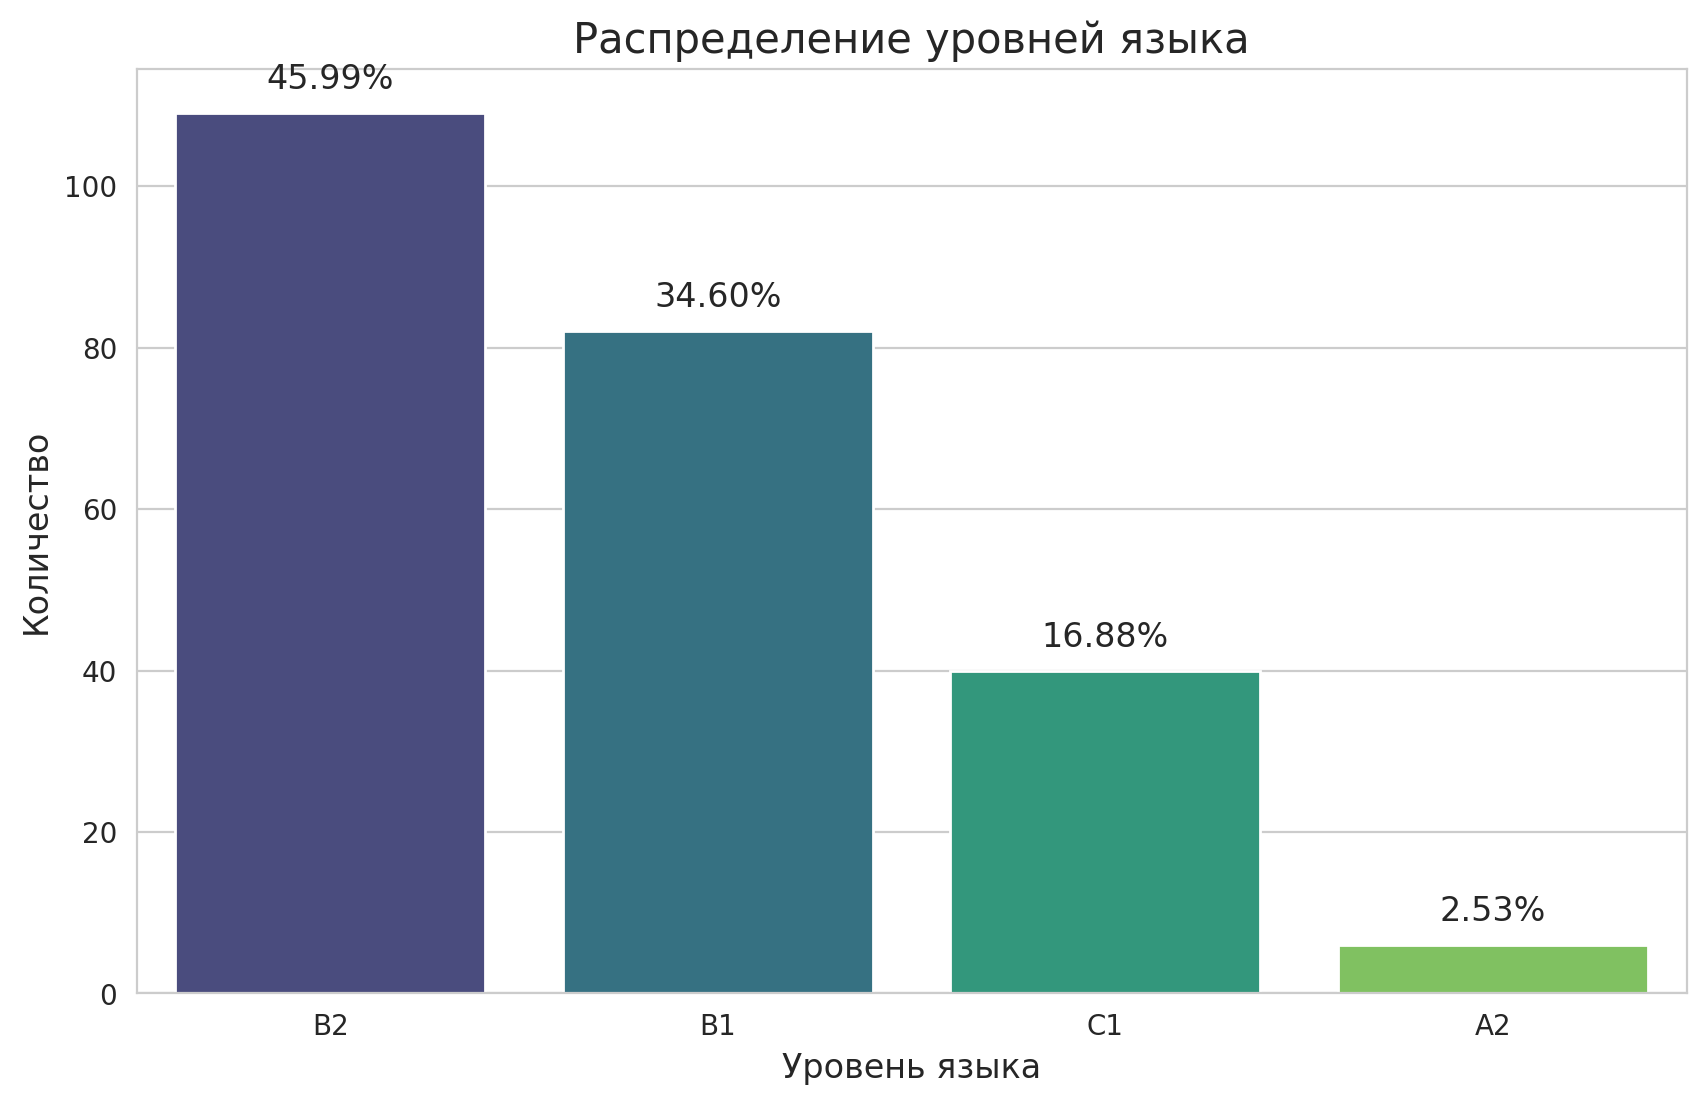

In [104]:
# Выводим количество для каждого класса
# Устанавливаем стиль "seaborn" для улучшения внешнего вида графиков
sns.set_style("whitegrid")

# Создаем гистограмму
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='level', order=df['level'].value_counts().index, palette='viridis')

# Задаем название гистограммы и осей
plt.title('Распределение уровней языка', fontsize=15)
plt.xlabel('Уровень языка', fontsize=12)
plt.ylabel('Количество', fontsize=12)

# Добавляем аннотации над каждым столбцом
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center", fontsize=12)

# Показываем гистограмму
plt.show()

### Разделение данных на целевой признак и признаки.

In [105]:
X = df.drop('level', axis=1)
y = df['level']

### Разделение на обучающий и тестовый наборы данных с учетом стратификации.

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Подбор и обучение модели.

### Обучение и подбор гиперпараметров для модели RandomForestClassifier.

In [112]:
rf_model = RandomForestClassifier(random_state=2023)
hyperparams = {'max_depth': [5, 6, 7, 8],
               'n_estimators': [50, 100, 150],
               'random_state': [2023]}

clf = GridSearchCV(rf_model, hyperparams, scoring='accuracy')
clf.fit(X_train, y_train)

best_params = clf.best_params_
rf_best_model = clf.best_estimator_

# Оценка метрик на лучшей модели
y_pred = rf_best_model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Расчет стандартного отклонения наилучшей модели
cv_results = clf.cv_results_
best_std = cv_results['std_test_score'][clf.best_index_]

print("Лучшие параметры модели RandomForestClassifier:", best_params)
print("Стандартное отклонение наилучшей модели RandomForestClassifier:", (best_std).round(2))
print("Метрика balanced_accuracy наилучшей модели RandomForestClassifier:", (balanced_accuracy).round(2))
print("Метрика accuracy наилучшей модели RandomForestClassifier:", (accuracy).round(2))
print("Метрика f1 наилучшей модели RandomForestClassifier:", (f1).round(2))

Лучшие параметры модели RandomForestClassifier: {'max_depth': 7, 'n_estimators': 50, 'random_state': 2023}
Стандартное отклонение наилучшей модели RandomForestClassifier: 0.05
Метрика balanced_accuracy наилучшей модели RandomForestClassifier: 0.75
Метрика accuracy наилучшей модели RandomForestClassifier: 0.73
Метрика f1 наилучшей модели RandomForestClassifier: 0.72


### Обучение и подбор гиперпараметров для модели CatBoostClassifier.

In [118]:
# Создаем Pool
train_pool = Pool(data=X_train, label=y_train)


def objective(trial):
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.03, 0.05, 0.07, 0.1])
    depth = trial.suggest_categorical("depth", [4, 6, 8])
    iterations = trial.suggest_categorical("iterations", [750, 1000, 1500])
    l2_leaf_reg = trial.suggest_categorical("l2_leaf_reg", [2, 3, 5])

    model = CatBoostClassifier(
        learning_rate=learning_rate,
        depth=depth,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
        random_seed=2023,
        eval_metric='Accuracy',
        verbose=0
    )
    model.fit(train_pool)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)

# Получение лучших параметров и метрик
best_params_cb = study.best_params
best_model_cb = CatBoostClassifier(**best_params_cb, random_seed=2023, verbose=0, eval_metric='Accuracy')
best_model_cb.fit(train_pool)

y_pred_cb = best_model_cb.predict(X_test)
balanced_accuracy_cb = balanced_accuracy_score(y_test, y_pred_cb)
accuracy_cb = accuracy_score(y_test, y_pred_cb)
f1_cb = f1_score(y_test, y_pred_cb, average='weighted')

print(f"Лучшие параметры модели CatBoostClassifier: {best_params_cb}")
print(f"Метрика balanced_accuracy наилучшей модели CatBoostClassifier: {balanced_accuracy_cb:.2f}")
print(f"Метрика accuracy наилучшей модели CatBoostClassifier: {accuracy_cb:.2f}")
print(f"Метрика f1 наилучшей модели CatBoostClassifier: {f1_cb:.2f}")

[I 2023-10-27 06:25:53,216] A new study created in memory with name: no-name-08e647fb-86fd-4fb8-9de6-e4b1921b61fd
[I 2023-10-27 06:26:23,878] Trial 0 finished with value: 0.8125 and parameters: {'learning_rate': 0.01, 'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.8125.
[I 2023-10-27 06:26:26,559] Trial 1 finished with value: 0.8125 and parameters: {'learning_rate': 0.01, 'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 3}. Best is trial 0 with value: 0.8125.
[I 2023-10-27 06:26:40,240] Trial 2 finished with value: 0.7916666666666666 and parameters: {'learning_rate': 0.03, 'depth': 6, 'iterations': 1500, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.8125.
[I 2023-10-27 06:26:42,529] Trial 3 finished with value: 0.8125 and parameters: {'learning_rate': 0.05, 'depth': 6, 'iterations': 1500, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.8125.
[I 2023-10-27 06:27:00,568] Trial 4 finished with value: 0.8125 and parameters: {'learning_rate': 0.07, 'depth

Лучшие параметры модели CatBoostClassifier: {'learning_rate': 0.01, 'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 5}
Метрика balanced_accuracy наилучшей модели CatBoostClassifier: 0.83
Метрика accuracy наилучшей модели CatBoostClassifier: 0.81
Метрика f1 наилучшей модели CatBoostClassifier: 0.81


**Вывод:** наилучшие метрики продемонстрировала модель CatBoostClassifier.

## Проверка модели на тестовых данных.

## Проверяем модель на тестовых данных.

In [120]:
%%time

# Создаем модель с лучшими параметрами

cb_model = CatBoostClassifier(learning_rate=0.01, depth=8, iterations=1000, l2_leaf_reg=5, eval_metric='Accuracy', verbose=False, random_seed=2023)

# Обучаем модель на тренировочных данных
cb_model.fit(X_train, y_train)

# Делаем предсказание на тестовом наборе
y_pred = cb_model.predict(X_test)

# Расчет метрик на тестовом наборе
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Выведение результатов на экран
print("Метрика balanced_accuracy модели CatBoostClassifier:", balanced_accuracy.round(2))
print("Метрика accuracy модели CatBoostClassifier:", accuracy.round(2))
print("Метрика f1 модели CatBoostClassifier:", f1.round(2))

Метрика balanced_accuracy модели CatBoostClassifier: 0.83
Метрика accuracy модели CatBoostClassifier: 0.81
Метрика f1 модели CatBoostClassifier: 0.81
CPU times: user 22.8 s, sys: 312 ms, total: 23.1 s
Wall time: 16.2 s


## Строим матрицу ошибок.

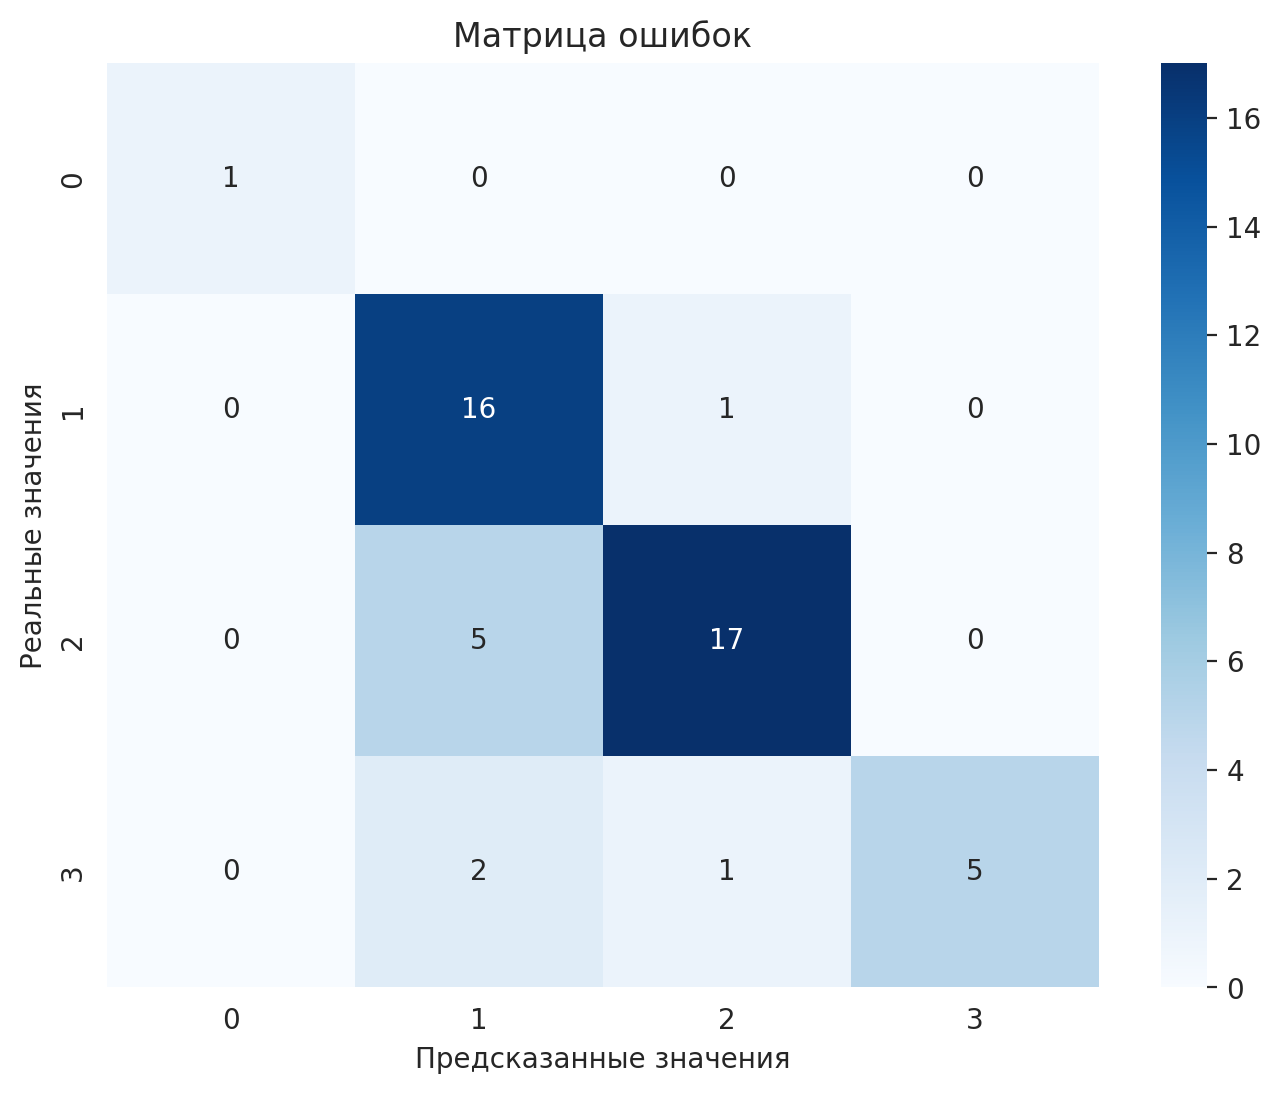

In [121]:
# Рассчитываем матрицу ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализируем матрицу ошибок
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.title('Матрица ошибок')
plt.show()

## Вычисляем важность признаков.

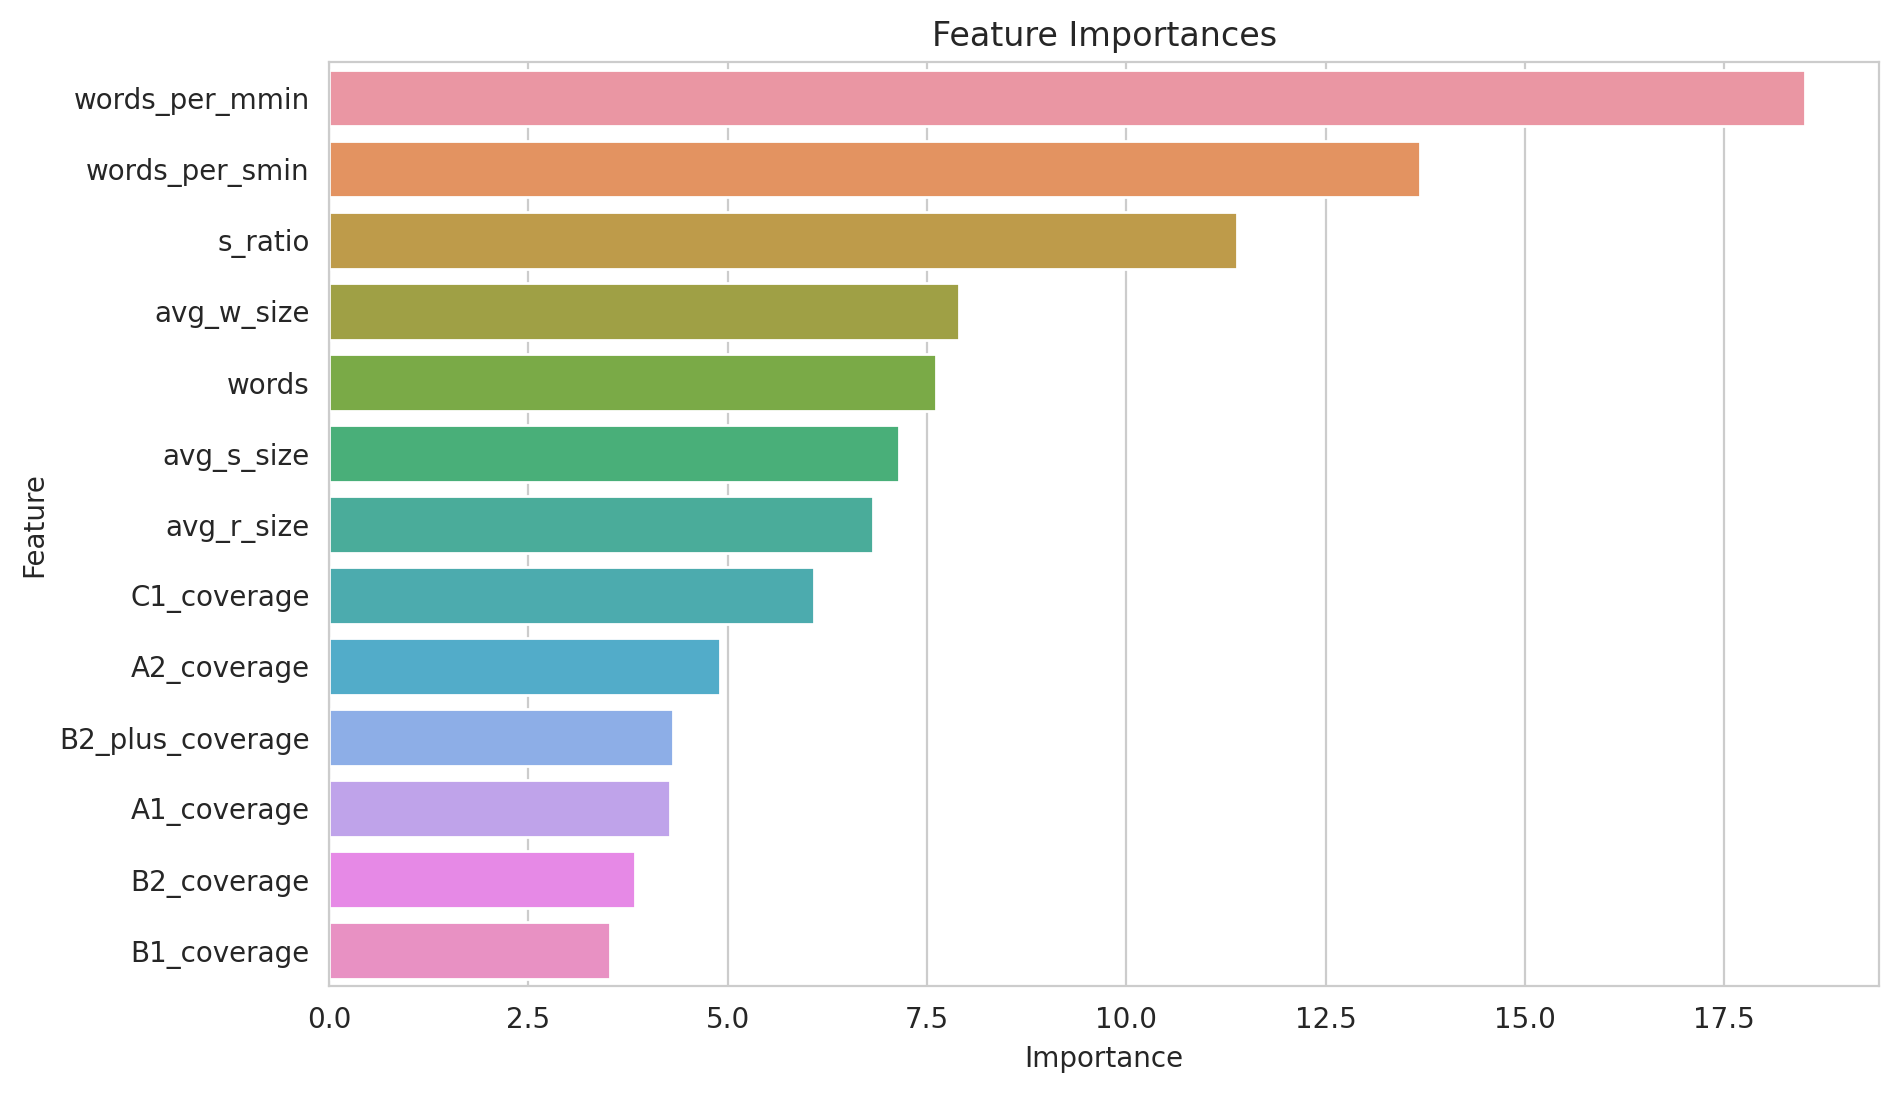

In [122]:
# Получение значимости признаков
feature_importances = cb_model.feature_importances_

# Создание DataFrame с информацией о признаках и их значимости
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Сортировка по значимости
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Вывод гистограммы значимости признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Вывод:

- **Лучшая модель подтвердила свою точность на тестовых данных.**
- **Наибольшую значимость следующие признаки: количество уникальных слов в минуту фильма, количество уникальных слов в минуту субтитров, доля длительности субтитров в длительности фильма.**

## Отчет по итогам проекта.

В рамках проекта были выполнены следующие основные этапы работы:

- Поиск файлов с субтитрами для каждого размеченного фильма при помощи библиотек pathlib и difflib.
- Извлечение в датасет текста субтитров из файлов при помощи библиотеки pysrt. Возникшая сложность - различная кодировка файлов с субтитрами. Решение - создание функции для определения кодировки файла и учет кодировки каждого файла при последующей работе с ними.
- Очистка текста субтитров от лишних символов, стоп-слов и имён, а также последующая лемматизация слов в тексте при помощи библиотек re, nltk и SpaCy. При этом для очистки текста от стоп-слов и имён использовалась библиотека nltk, а для лемматизации - библиотека SpaCy.
- Извлечение списка слов по уровням CEFR из файлов от Oxford в формате pdf при помощи библиотеки fitz.
- Этап feature engineering: датасет был дополнен столбцами со следующими признаками:
        - количество уникальных слов,
        - длительность субтитров в фильме,
        - длительность фильма,
        - доля длительности субтитров в длительности фильма,
        - количество уникальных слов в минуту субтитров,
        - количество уникальных слов в минуту фильма,
        - средняя длина слов в фильме (в буквах),
        - средняя длина предложений в фильме (в словах),
        - средняя длина реплик в фильме (в словах),
        - степень покрытия уникальных слов из фильма списками слов по шкале CEFR (A1, A2, B1, B2, B2+, C1).

- Далее были обучены две модели c подбором оптимальных гиперпараметров методом grid_search: RandomForestClassifier и CatboostClassifier. При этом метрики accuracy, balanced_accuracy и f1 были значительно ниже при обучении моделей на признаках, включающих в себя векторы очищенных текстов.

- При обучении моделей без векторов очищенных текстов они показали метрику balanced accuracy не ниже 0.75. При этом лучший результат показала модель CatboostClassifier (balanced accuracy ≈ 0.83).

- Наибольшую значимость для наилучшей модели имеют следующие признаки: количество уникальных слов в минуту фильма, количество уникальных слов в минуту субтитров, доля длительности субтитров в длительности фильма.